In [38]:
from langchain.document_loaders import DirectoryLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
import os
import requests
from dotenv import load_dotenv
import openai 
from langchain.evaluation import load_evaluator

In [63]:
load_dotenv(override=True)
api_key = os.getenv("OPENAI_API_KEY")


In [64]:
crome_path = "Crome"
os.makedirs(crome_path, exist_ok=True)

# Embedding and calculating the distance of words

In [27]:
embedd = OpenAIEmbeddings(api_key=api_key)
vector = embedd.embed_query("apple")
len(vector)


1536

In [32]:
evaluation = load_evaluator("pairwise_embedding_distance")


In [35]:
x= evaluation.evaluate_string_pairs(prediction='apple', prediction_b= "orange")
x

{'score': 0.13554126333631666}

In [36]:
x= evaluation.evaluate_string_pairs(prediction='apple', prediction_b= "beach")
x

{'score': 0.2025086681583368}

In [37]:
x= evaluation.evaluate_string_pairs(prediction='apple', prediction_b= "apple")
x

{'score': 1.1102230246251565e-16}

# Query for relevant data

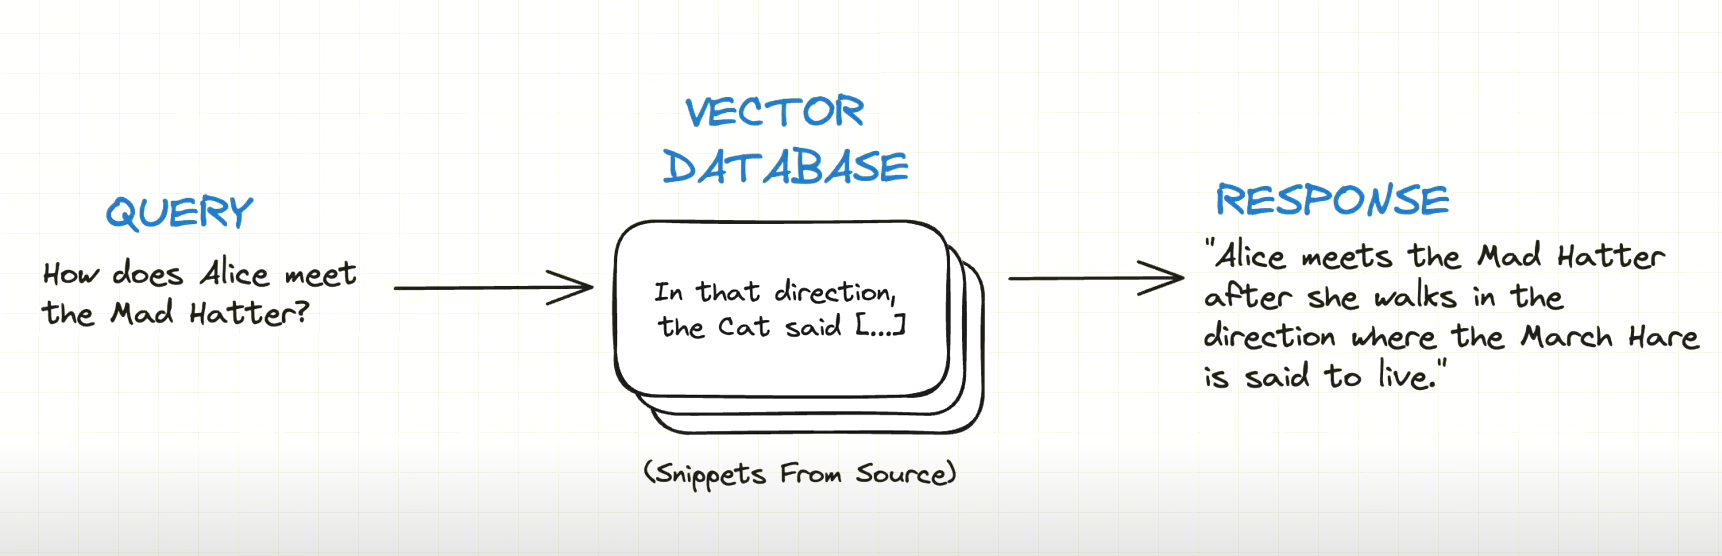

In [45]:
chunks_text = """Abstract—Recent studies on learning-based sound source localization have primarily focused on localization performance.
However, prior work and existing benchmarks often overlook a
crucial aspect: 
"""
chunks = [Document(page_content=chunks_text)]
chunks

[Document(metadata={}, page_content='Abstract—Recent studies on learning-based sound source localization have primarily focused on localization performance.\nHowever, prior work and existing benchmarks often overlook a\ncrucial aspect: \n')]

In [46]:
db = Chroma.from_documents(chunks, embedd, persist_directory=crome_path)

In [61]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.evaluation import load_evaluator
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import openai
import os
import shutil
from langchain.prompts import ChatPromptTemplate

In [49]:
# Cell 1: Import libraries and load environment variables

# Load environment variables from .env file
load_dotenv()

# Set OpenAI API key
openai.api_key = os.environ['OPENAI_API_KEY']

# Define paths for data and Chroma database
CHROMA_PATH = "chroma"
DATA_PATH = "book"

# Cell 2: Function to load and process documents
def load_documents():
    """Load Markdown documents from the specified directory."""
    loader = DirectoryLoader(DATA_PATH, glob="*.md")
    documents = loader.load()
    return documents

def split_text(documents: list[Document]):
    """Split documents into smaller chunks for processing."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=300,
        chunk_overlap=100,
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")
    
    # Display sample chunk for verification
    if len(chunks) > 10:
        document = chunks[10]
        print("Sample chunk content:", document.page_content)
        print("Sample chunk metadata:", document.metadata)
    
    return chunks

def save_to_chroma(chunks: list[Document]):
    """Save document chunks to Chroma vector store."""
    # Clear out the database if it exists
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)
    
    # Create a new Chroma database from the documents
    db = Chroma.from_documents(
        chunks, OpenAIEmbeddings(), persist_directory=CHROMA_PATH
    )
    db.persist()
    print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")

def generate_data_store():
    """Main function to process documents and save to Chroma."""
    documents = load_documents()
    chunks = split_text(documents)
    save_to_chroma(chunks)

# Cell 3: Function to evaluate word embeddings
def evaluate_embeddings():
    """Generate and compare embeddings for words using OpenAI."""
    # Get embedding for a word
    embedding_function = OpenAIEmbeddings()
    vector = embedding_function.embed_query("apple")
    print(f"Vector for 'apple': {vector[:10]}... (truncated for display)")
    print(f"Vector length: {len(vector)}")

    # Compare vector of two words
    evaluator = load_evaluator("pairwise_embedding_distance")
    words = ("apple", "iphone")
    result = evaluator.evaluate_string_pairs(prediction=words[0], prediction_b=words[1])
    print(f"Comparing ({words[0]}, {words[1]}): {result}")

# Cell 4: Execute document processing
# Run this cell to process documents and save to Chroma
generate_data_store()

# Cell 5: Execute embedding evaluation
# Run this cell to evaluate word embeddings
evaluate_embeddings()

Split 1 documents into 818 chunks.
Sample chunk content: So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
Sample chunk metadata: {'source': 'book/alice_book.md', 'start_index': 1653}


/tmp/ipykernel_3219854/1214543024.py:59: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


Saved 818 chunks to chroma.
Vector for 'apple': [0.007730893790721893, -0.023138046264648438, -0.007587476167827845, -0.02780936472117901, -0.0046508293598890305, 0.013010028749704361, -0.021963387727737427, -0.008393346332013607, 0.018958445638418198, -0.029557693749666214]... (truncated for display)
Vector length: 1536
Comparing (apple, iphone): {'score': 0.0971067558490869}


In [59]:
PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""
def process_query(query_text: str):

    """Process a query using the Chroma vector store and generate a response."""
    try:
        # Prepare the DB
        embedding_function = OpenAIEmbeddings()
        db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

        # Search the DB
        results = db.similarity_search_with_relevance_scores(query_text, k=3)
        if len(results) == 0 or results[0][1] < 0.7:
            print(f"Unable to find matching results for query: {query_text}")
            return

        # Create prompt with context
        context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
        prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
        prompt = prompt_template.format(context=context_text, question=query_text)
        print("Generated Prompt:\n", prompt)

        # Generate response using OpenAI model
        model = ChatOpenAI()
        response_text = model.predict(prompt)

        # Collect sources
        sources = [doc.metadata.get("source", None) for doc, _score in results]
        formatted_response = f"Response: {response_text}\nSources: {sources}"
        print(formatted_response)
    except Exception as e:
        print(f"Error in process_query: {str(e)}")

In [60]:
query_text = input("How does Alice meet the Mad Hatter") 
process_query(query_text)

How does Alice meet the Mad Hatter "How does Alice meet the Mad Hatter"


Generated Prompt:
 Human: 
Answer the question based only on the following context:

“In that direction,” the Cat said, waving its right paw round, “lives a Hatter: and in that direction,” waving the other paw, “lives a March Hare. Visit either you like: they’re both mad.”

“But I don’t want to go among mad people,” Alice remarked.

---

So Alice began telling them her adventures from the time when she first saw the White Rabbit. She was a little nervous about it just at first, the two creatures got so close to her, one on each side, and opened their eyes and mouths so very wide, but she gained courage as she went on. Her listeners

---

“Tell us a story!” said the March Hare.

“Yes, please do!” pleaded Alice.

“And be quick about it,” added the Hatter, “or you’ll be asleep again before it’s done.”

---

Answer the question based on the above context: "How does Alice meet the Mad Hatter"



/tmp/ipykernel_3219854/2057554650.py:32: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response_text = model.predict(prompt)


Response: Alice meets the Mad Hatter when the Cat tells her that the Hatter lives in a certain direction, and Alice decides to visit him.
Sources: ['book/alice_book.md', 'book/alice_book.md', 'book/alice_book.md']
